In [16]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
from itertools import islice
from sortedcontainers import SortedDict 

In [17]:
def annualize_factor_2021():
    return 365 / (datetime.datetime.fromtimestamp(last_ts) - datetime.datetime(2021,1,1)).days

annualize_factor_2021()

2.134502923976608

In [18]:
# from https://stackoverflow.com/questions/7934547
def closest(sorted_dict, key):
    "Return closest key in `sorted_dict` to given `key`."
    keys = list(islice(sorted_dict.irange(minimum=key), 1))
    keys.extend(islice(sorted_dict.irange(maximum=key, reverse=True), 1))
    return min(keys, key=lambda k: abs(key - k))

## 1. Daily electricity consumption of the Bitcoin network

* Data sources
    * `total_energy_df`: [Cambridge Bitcoin Electricity Consumption Index](https://cbeci.org/); contains daily estimates of annualized total electricity consumption everyday since 2014-07-01 (in TWh/year)

In [19]:
total_energy_df = pd.read_csv("./source/cbeci_export.csv")
total_energy_df.head()

,Timestamp,Date and Time,MAX,MIN,GUESS
0,1404172800,2014-07-01T00:00:00,11.6968,9.84480,10.72210
1,1404259200,2014-07-02T00:00:00,11.8727,5.31064,8.33358
2,1404345600,2014-07-03T00:00:00,11.9899,3.80303,7.56635
3,1404432000,2014-07-04T00:00:00,12.6422,3.08748,7.47565
4,1404518400,2014-07-05T00:00:00,12.7873,2.64228,7.29972


In [20]:
first_ts = total_energy_df.iloc[0]['Timestamp']
last_ts = total_energy_df.iloc[-1]['Timestamp']

first_ts, last_ts

(1404172800, 1624320000)

In [21]:
total_energy_df['datetime'] = pd.to_datetime(total_energy_df['Date and Time'])
total_energy_df['lower_gwh_d'] = total_energy_df['MIN'] * 1000 / 365
total_energy_df['upper_gwh_d'] = total_energy_df['MAX'] * 1000 / 365
total_energy_df['estimated_gwh_d'] = total_energy_df['GUESS'] * 1000 / 365

In [22]:
df = total_energy_df[['datetime', 'lower_gwh_d', 'upper_gwh_d', 'estimated_gwh_d']]
df = df.set_index(total_energy_df['datetime'])

In [23]:
df.head()

,datetime,lower_gwh_d,upper_gwh_d,estimated_gwh_d
datetime,,,,
2014-07-01,2014-07-01,26.972055,32.046027,29.375616
2014-07-02,2014-07-02,14.549699,32.527945,22.831726
2014-07-03,2014-07-03,10.419260,32.849041,20.729726
2014-07-04,2014-07-04,8.458849,34.636164,20.481233
2014-07-05,2014-07-05,7.239123,35.033699,19.999233


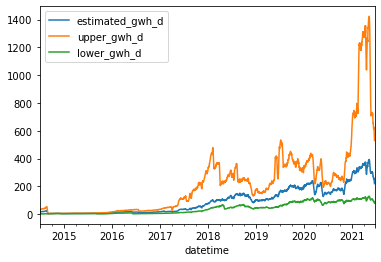

In [24]:
df[['estimated_gwh_d', 'upper_gwh_d', 'lower_gwh_d']].plot()

## 2. Emission factor of Bitcoin mining based on geographic distribution of hashrate and energy mixes

The unit of resulting emission factor is kgCO2e / kWh

In [25]:
emission_factor_df = pd.read_csv("./source/emission_factor.csv")
emission_factor_df

,Country,Emission Factor,Source,Year
0,Russia,0.352,IFI CM EC,2019
1,US,0.285,IFI CM EC,2019
2,Malaysia,0.470,IFI CM EC,2019
3,Iran,0.470,IFI CM EC,2019
4,Kazakhstan,0.653,IFI CM EC,2019
5,Libya,0.538,IFI CM EC,2019
6,Canada,0.231,IFI CM EC,2019
7,Norway,0.061,IFI CM EC,2019
8,Germany,0.366,IFI CM EC,2019
9,Thailand,0.390,IFI CM EC,2019


In [26]:
def emission_factor_by_country(country: str):
    return round(float(emission_factor_df[emission_factor_df['Country'] == country]['Emission Factor']), 5)

emission_factor_by_country("China_Beijing")

0.8

In [27]:
hashrate_dist_df = pd.read_csv("./source/btc_hashrate_distribution.csv")
hashrate_dist_df.head()

,Year,Month,Country,Hashrate Distribution
0,2019,9,China_Xinjiang,0.3178
1,2019,9,China_Sichuan,0.1960
2,2019,9,China_Nei_Mongol,0.0813
3,2019,9,China_RoC,0.0766
4,2019,9,Russia,0.0593


In [28]:

hashrate_dist_df = hashrate_dist_df.replace("Rest", "World")
hashrate_dist_df['emission_factor'] = hashrate_dist_df['Country'].apply(lambda x: emission_factor_by_country(x))
hashrate_dist_df['emission_factor_dist'] = hashrate_dist_df['emission_factor'] * hashrate_dist_df['Hashrate Distribution']
emission_factors_ser = hashrate_dist_df.groupby(['Year', 'Month'])['emission_factor_dist'].sum()

In [29]:
emf = {}
for ym, v in emission_factors_ser.items():
    
    ts = int(datetime.datetime(ym[0], ym[1], 1).timestamp())
    emf[ts] = v
emission_factors = SortedDict(emf)


In [30]:
emission_factors

SortedDict({1567321200: 0.6421450999999999, 1569913200: 0.6395414999999998, 1572591600: 0.6305423000000001, 1575187200: 0.6369704999999999, 1577865600: 0.6387163999999999, 1580544000: 0.6348021000000001, 1583049600: 0.6246918000000002, 1585724400: 0.6183217999999999})

In [31]:
def btc_emission_factor_by_ts(timestamp):
    """
    Returns the BTC emission factor closest to timestamp.
    This value represents overall emission factor kgCO2/kWh of the Bitcoin network
    considering the geographic distribution of hashrate and the energy mix and emission factor
    of each mining region. 
    """
    # return emission_factors.get(timestamp, emission_factors[min(emission_factors.keys(), key=lambda k: abs(k-timestamp))]) 
    return emission_factors[closest(emission_factors, timestamp)]


btc_emission_factor_by_ts(datetime.datetime.now().timestamp())

0.6183217999999999

## 3. Daily carbon emissions of the Bitcoin network

emission (tCO2e) = energy (gWh) \* emission_factor (kgCO2e/kWh) * 1000

In [42]:
df['emission_factor'] = df.apply(lambda x: btc_emission_factor_by_ts(x['datetime'].timestamp()), axis=1)
df['em_l'] = df['lower_gwh_d'] * df['emission_factor'] * 1000
df['em_u'] = df['upper_gwh_d'] * df['emission_factor'] * 1000
df['em_e'] = df['estimated_gwh_d'] * df['emission_factor'] * 1000

df[['em_l', 'em_u', 'em_e']].tail()

,em_l,em_u,em_e
datetime,,,
2021-06-18,57722.796377,386818.730015,160576.138621
2021-06-19,55440.257217,371523.312119,154226.397243
2021-06-20,53388.445260,357772.851706,148518.524715
2021-06-21,51506.375343,345160.781019,143282.948399
2021-06-22,48997.005255,328344.122091,136302.010576


In [43]:
daily_emissions = {}

for dt, row in df[['datetime', 'em_l', 'em_u', 'em_e']].iterrows():
    daily_emissions[int(dt.timestamp())] = (row[1], row[2], row[3])

daily_emissions = SortedDict(daily_emissions)


### Comparing with Digiconomist's value
Digiconomist reports annualized total bitcoin footprints as 63.12 Mt CO2 as of 2021-06-29

In [45]:
63.12 * 1000000 / 365

172931.50684931508

## 4. Daily supply of Bitcoin

In [51]:
# total BTC in circulation
supply_df = pd.read_csv("./source/total-bitcoins.csv")
supply_df.index = supply_df['timestamp']
supply_df.tail()

,timestamp,supply
timestamp,,
1623438230,1623438230,18732487.50
1623740706,1623740706,18735306.25
1624038001,1624038001,18738100.00
1624417918,1624417918,18740893.75
1624833061,1624833061,18743693.75


In [61]:
supply_ser = supply_df['supply'].squeeze()
supply_ser

timestamp
1231006505          50.00
1231933666       22400.00
1232270118       44750.00
1232633711       67100.00
1232891596       89450.00
                 ...     
1623438230    18732487.50
1623740706    18735306.25
1624038001    18738100.00
1624417918    18740893.75
1624833061    18743693.75
Name: supply, Length: 1501, dtype: float64

In [63]:
supplies = {}
for timestamp, supply in supply_ser.items():
    supplies[timestamp] = supply
supplies = SortedDict(supplies)

In [64]:
def supply_by_ts(timestamp):
    """
    Returns the BTC supply for a given timestamp
    """
    return supplies[closest(supplies, timestamp)]

supply_by_ts(datetime.datetime.now().timestamp())


18743693.75

In [70]:
ACTIVE_SUPPLY = 0.8

df['supply'] = df.apply(lambda x: supply_by_ts(x['datetime'].timestamp()), axis=1) * ACTIVE_SUPPLY
df

,datetime,lower_gwh_d,upper_gwh_d,estimated_gwh_d,emission_factor,em_l,em_u,em_e,supply,1btc_l,1btc_u,1btc_e
datetime,,,,,,,,,,,,
2014-07-01,2014-07-01,26.972055,32.046027,29.375616,0.642145,17319.972823,20578.199468,18863.408155,10373400.0,1.335722,1.586997,1.454752
2014-07-02,2014-07-02,14.549699,32.527945,22.831726,0.642145,9343.017682,20887.660627,14661.280993,10373400.0,0.720537,1.610863,1.130683
2014-07-03,2014-07-03,10.419260,32.849041,20.729726,0.642145,6690.676931,21093.850779,13311.491993,10382840.0,0.515518,1.625286,1.025653
2014-07-04,2014-07-04,8.458849,34.636164,20.481233,0.642145,5431.808639,22241.443242,13151.923334,10382840.0,0.418522,1.713708,1.013358
2014-07-05,2014-07-05,7.239123,35.033699,19.999233,0.642145,4648.567547,22496.717910,12842.409396,10382840.0,0.358173,1.733377,0.989510
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-18,2021-06-18,93.353973,625.594521,259.696712,0.618322,57722.796377,386818.730015,160576.138621,14990480.0,3.080504,20.643434,8.569500
2021-06-19,2021-06-19,89.662466,600.857534,249.427397,0.618322,55440.257217,371523.312119,154226.397243,14990480.0,2.958692,19.827160,8.230632
2021-06-20,2021-06-20,86.344110,578.619178,240.196164,0.618322,53388.445260,357772.851706,148518.524715,14990480.0,2.849192,19.093337,7.926018


## 5. Daily carbon emissions of holding 1 BTC

emission_1btc (kgCO2) = emission_total (tCO2) / supply * 1000

In [71]:
df['1btc_l'] = df['em_l'] * 1000 / df['supply']
df['1btc_u'] = df['em_u'] * 1000 / df['supply']
df['1btc_e'] = df['em_e'] * 1000 / df['supply']
df[['1btc_l', '1btc_u', '1btc_e']]

,1btc_l,1btc_u,1btc_e
datetime,,,
2014-07-01,1.669652,1.983747,1.818440
2014-07-02,0.900671,2.013579,1.413353
2014-07-03,0.644398,2.031607,1.282067
2014-07-04,0.523152,2.142135,1.266698
2014-07-05,0.447716,2.166721,1.236888
...,...,...,...
2021-06-18,3.850630,25.804292,10.711874
2021-06-19,3.698364,24.783950,10.288289
2021-06-20,3.561490,23.866671,9.907523


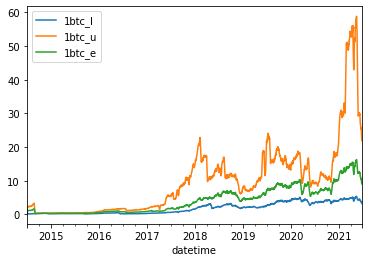

In [72]:
df[['1btc_l', '1btc_u', '1btc_e']].plot()

### CSV Exports


In [74]:
df[['1btc_l', '1btc_u', '1btc_e']].to_csv('1btc_emission_daily.csv', float_format='%g')

## 6. Aggregate analysis 

In [76]:
yearly_df = df.groupby(df.datetime.dt.year).agg({'1btc_l': 'sum', '1btc_u': 'sum', '1btc_e': 'sum'})
yearly_df

,1btc_l,1btc_u,1btc_e
datetime,,,
2014,47.534517,195.098864,115.305443
2015,82.158189,179.884492,126.935841
2016,107.408177,512.081035,279.826551
2017,259.870470,2197.939820,643.705444
2018,885.804871,4737.037660,1949.438735
2019,1056.686287,4983.063003,2431.899189
2020,1454.164101,4856.704239,2949.267945
2021,790.976400,7136.595778,2316.346154


In [77]:
yearly_df[yearly_df.index == 2021][['1btc_l', '1btc_u', '1btc_e']] * annualize_factor_2021()

,1btc_l,1btc_u,1btc_e
datetime,,,
2021,1688.341439,15233.084555,4944.247639


In 2021, holding 1 BTC for a year would produce a carbon footprint of 4944 kg.